# Jet Compression using an Autoencoder

In [1]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [5]:
print(train.shape, test.shape)

(1550321, 4) (387581, 4)


## Training

In [5]:
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

In [6]:
class AE_3D(nn.Module): # v2
    def __init__(self, n_features=4):
        super(AE_3D, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [7]:
n_features = len(train.loc[0])
model = AE_3D()

In [8]:
# Training
epochs_list = [7, 5, 3, 2, 2]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch 0: Validation loss = 0.00042727460652522116 Time: -1 day, 23:58:37.987140
Epoch 1: Validation loss = 0.0003279707704431853 Time: -1 day, 23:57:14.528198
Epoch 2: Validation loss = 0.00025855514111431483 Time: -1 day, 23:55:50.101195
Epoch 3: Validation loss = 0.0012257255314069575 Time: -1 day, 23:54:28.487339
Epoch 4: Validation loss = 0.0007194810400719885 Time: -1 day, 23:53:06.159422
Epoch 5: Validation loss = 0.0009939698773758067 Time: -1 day, 23:51:43.281954
Epoch 6: Validation loss = 0.0005347722472963382 Time: -1 day, 23:50:21.860548
Setting learning rate to 3.0e-04
Epoch 0: Validation loss = 5.329549598585246e-05 Time: -1 day, 23:58:38.043555
Epoch 1: Validation loss = 0.0006682505681179863 Time: -1 day, 23:57:12.527953
Epoch 2: Validation loss = 0.0001782447774418444 Time: -1 day, 23:55:40.552752
Epoch 3: Validation loss = 4.0762649880298495e-05 Time: -1 day, 23:54:09.851799
Epoch 4: Validation loss = 8.114936901980109e-05 Time: -1 day,

In [15]:
opt = optim.Adam(model.parameters(), lr=1e-4)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch 0: Validation loss = 1.218568337299793e-05 Time: -1 day, 23:58:36.176724
Epoch 1: Validation loss = 1.0448504017008741e-05 Time: -1 day, 23:56:55.989659
Epoch 2: Validation loss = 2.8092690438922067e-05 Time: -1 day, 23:55:13.148124
Epoch 3: Validation loss = 2.0870285266270185e-05 Time: -1 day, 23:53:31.782459
Epoch 4: Validation loss = 6.390444046355849e-05 Time: -1 day, 23:51:57.314331
Epoch 5: Validation loss = 0.00012021899610072603 Time: -1 day, 23:50:01.623879
Epoch 6: Validation loss = 2.654630335312097e-05 Time: -1 day, 23:48:09.271962
Epoch 7: Validation loss = 2.527665200104891e-05 Time: -1 day, 23:46:32.181426
Epoch 8: Validation loss = 1.808658732149106e-05 Time: -1 day, 23:44:52.120548
Epoch 9: Validation loss = 8.179337322325226e-06 Time: -1 day, 23:43:15.097050


In [16]:
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch 0: Validation loss = 7.441587602577079e-06 Time: -1 day, 23:58:26.698584
Epoch 1: Validation loss = 5.974595451642551e-06 Time: -1 day, 23:57:02.775225
Epoch 2: Validation loss = 5.817303943374606e-06 Time: -1 day, 23:55:39.523896
Epoch 3: Validation loss = 5.894190604996993e-06 Time: -1 day, 23:54:14.672514
Epoch 4: Validation loss = 5.5349830918747895e-06 Time: -1 day, 23:52:48.194821
Epoch 5: Validation loss = 5.747196191828318e-06 Time: -1 day, 23:51:25.973846
Epoch 6: Validation loss = 6.088950805820509e-06 Time: -1 day, 23:50:04.507217
Epoch 7: Validation loss = 5.4845926779196e-06 Time: -1 day, 23:48:43.856658
Epoch 8: Validation loss = 5.151438369860045e-06 Time: -1 day, 23:47:23.716497
Epoch 9: Validation loss = 5.029797857733067e-06 Time: -1 day, 23:45:59.024871


In [19]:
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch 0: Validation loss = 4.9359732570314644e-06 Time: -1 day, 23:58:14.074741
Epoch 1: Validation loss = 4.695196557901953e-06 Time: -1 day, 23:56:30.050659
Epoch 2: Validation loss = 5.532358651938478e-06 Time: -1 day, 23:54:52.769433
Epoch 3: Validation loss = 4.784230612951841e-06 Time: -1 day, 23:53:05.112475
Epoch 4: Validation loss = 4.377442885242043e-06 Time: -1 day, 23:51:23.357399
Epoch 5: Validation loss = 5.0285315444636975e-06 Time: -1 day, 23:49:41.879581
Epoch 6: Validation loss = 4.508018327100794e-06 Time: -1 day, 23:48:06.028088
Epoch 7: Validation loss = 4.325588895015594e-06 Time: -1 day, 23:46:21.803085
Epoch 8: Validation loss = 4.293799312633182e-06 Time: -1 day, 23:44:49.520222
Epoch 9: Validation loss = 4.08038028046296e-06 Time: -1 day, 23:43:09.768967


In [21]:
opt = optim.Adam(model.parameters(), lr=3e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch 0: Validation loss = 3.824367888281134e-06 Time: -1 day, 23:58:26.814932
Epoch 1: Validation loss = 3.6997817008833586e-06 Time: -1 day, 23:56:31.135149
Epoch 2: Validation loss = 3.7442505404478268e-06 Time: -1 day, 23:54:39.144352
Epoch 3: Validation loss = 3.704671128111804e-06 Time: -1 day, 23:52:47.782014
Epoch 4: Validation loss = 3.6902126284170976e-06 Time: -1 day, 23:50:57.152355
Epoch 5: Validation loss = 3.611559256766053e-06 Time: -1 day, 23:49:09.720915
Epoch 6: Validation loss = 3.7362884405654056e-06 Time: -1 day, 23:47:21.748950
Epoch 7: Validation loss = 3.704426100055873e-06 Time: -1 day, 23:45:34.557633
Epoch 8: Validation loss = 3.5710263296247947e-06 Time: -1 day, 23:43:44.882271
Epoch 9: Validation loss = 3.554659376433047e-06 Time: -1 day, 23:41:56.165951


In [23]:
opt = optim.Adam(model.parameters(), lr=3e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch 0: Validation loss = 3.4784936427245467e-06 Time: -1 day, 23:58:36.742648
Epoch 1: Validation loss = 3.4782153363848746e-06 Time: -1 day, 23:57:12.255622
Epoch 2: Validation loss = 3.4678570142927536e-06 Time: -1 day, 23:55:40.303901
Epoch 3: Validation loss = 3.4602402547822015e-06 Time: -1 day, 23:54:08.862309
Epoch 4: Validation loss = 3.5350402142356916e-06 Time: -1 day, 23:52:38.920789
Epoch 5: Validation loss = 3.4205505342447843e-06 Time: -1 day, 23:51:09.309015
Epoch 6: Validation loss = 3.504136795785868e-06 Time: -1 day, 23:49:39.237374
Epoch 7: Validation loss = 3.3137670416335757e-06 Time: -1 day, 23:48:08.897143
Epoch 8: Validation loss = 3.7542345730302856e-06 Time: -1 day, 23:46:38.439749
Epoch 9: Validation loss = 3.325188181371104e-06 Time: -1 day, 23:45:09.396857


In [25]:
opt = optim.Adam(model.parameters(), lr=1e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch 0: Validation loss = 3.1945744137009152e-06 Time: -1 day, 23:58:17.270295
Epoch 1: Validation loss = 3.1966580271356393e-06 Time: -1 day, 23:56:17.889579
Epoch 2: Validation loss = 3.1728578359972964e-06 Time: -1 day, 23:54:09.453297
Epoch 3: Validation loss = 3.2075893114225452e-06 Time: -1 day, 23:52:05.828179
Epoch 4: Validation loss = 3.194378518027433e-06 Time: -1 day, 23:50:00.963468
Epoch 5: Validation loss = 3.1778340482678646e-06 Time: -1 day, 23:47:48.274116
Epoch 6: Validation loss = 3.2062885406826057e-06 Time: -1 day, 23:45:19.472973
Epoch 7: Validation loss = 3.1262744034000893e-06 Time: -1 day, 23:43:23.377063
Epoch 8: Validation loss = 3.1385835437511577e-06 Time: -1 day, 23:41:45.979915
Epoch 9: Validation loss = 3.1052917752574142e-06 Time: -1 day, 23:40:16.613224


In [27]:
opt = optim.Adam(model.parameters(), lr=1e-6)
fit(30, model, loss_func, opt, train_dl, valid_dl, device)

Epoch 0: Validation loss = 3.1208633782569025e-06 Time: -1 day, 23:58:36.700326
Epoch 1: Validation loss = 3.1079251036628876e-06 Time: -1 day, 23:57:11.870068
Epoch 2: Validation loss = 3.066406315017003e-06 Time: -1 day, 23:55:27.372174
Epoch 3: Validation loss = 3.087935241208269e-06 Time: -1 day, 23:53:45.770083
Epoch 4: Validation loss = 3.0702229591011982e-06 Time: -1 day, 23:52:07.159830
Epoch 5: Validation loss = 3.049097983622696e-06 Time: -1 day, 23:50:30.945669
Epoch 6: Validation loss = 3.0331643728447603e-06 Time: -1 day, 23:48:54.740681
Epoch 7: Validation loss = 3.0417078567418604e-06 Time: -1 day, 23:47:18.922497
Epoch 8: Validation loss = 3.0265173121966407e-06 Time: -1 day, 23:45:48.574309
Epoch 9: Validation loss = 3.112202551489177e-06 Time: -1 day, 23:44:25.096954
Epoch 10: Validation loss = 2.99904648054464e-06 Time: -1 day, 23:43:02.889801
Epoch 11: Validation loss = 2.9864882233889574e-06 Time: -1 day, 23:41:40.520355
Epoch 12: Validation loss = 3.04872511023355

In [29]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_3D_v2_bs256_loss28eneg7.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [30]:
model.eval()

AE_3D(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [31]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6850, -0.7091,  1.6959,  0.2734], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1768, -0.1646, -0.0310, -0.5935], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3741,  0.6505,  1.3036, -0.5509], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3717, -0.0072,  1.0897, -0.7273], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7823, -0.3969,  1.1575, -0.7659], grad_fn=<AddBackward0>)
 


In [32]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [430.6787     -1.152757    3.0978954 752.1524   ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.4779137e+02 -2.8423893e-01 -4.7612809e-02  2.5917880e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [180.98077     1.0158684   2.3832366 283.36844  ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [ 1.8126926e+02 -3.3117883e-02  1.9937130e+00  1.8305246e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [131.48422    -0.6547884   2.117223  161.1287   ]
 


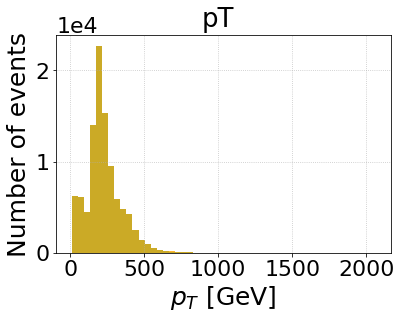

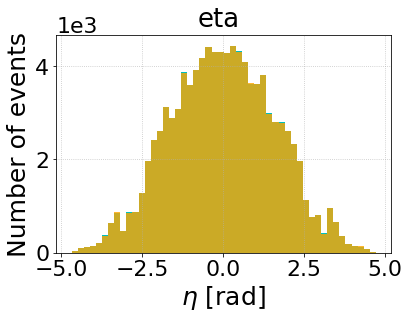

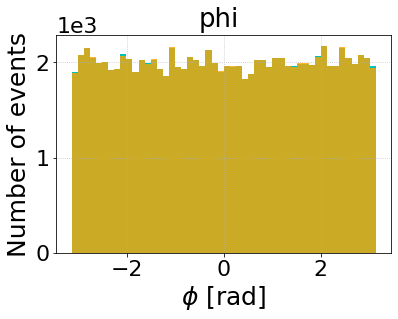

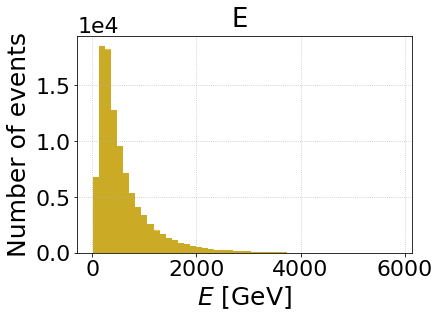

In [33]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()

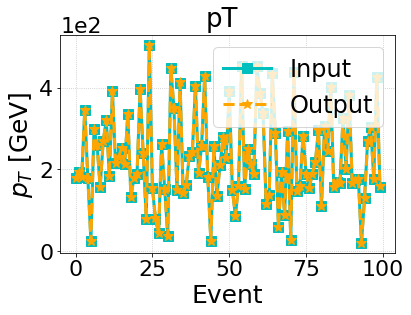

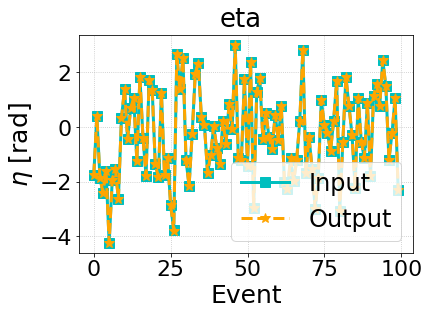

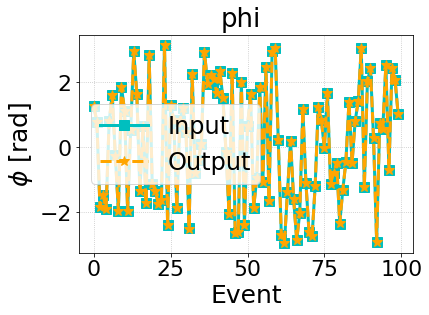

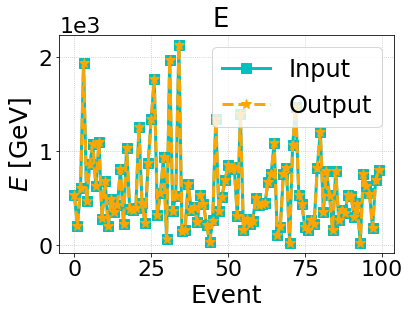

In [34]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [35]:
# Plot input on top of output
idxs = (0, int(1.9e6))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

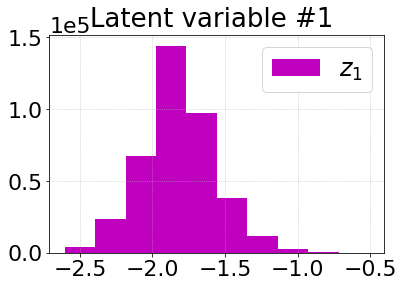

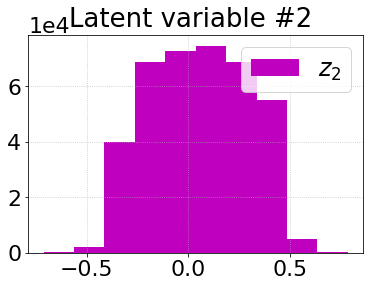

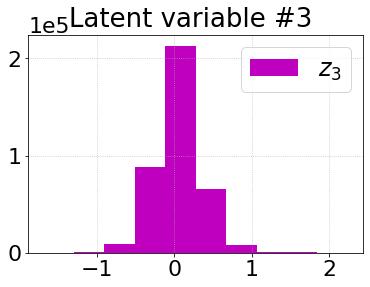

In [36]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0.5, 0, '$z_3$')

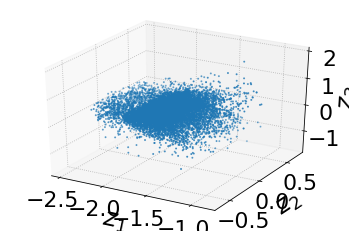

In [37]:
from mpl_toolkits.mplot3d import Axes3D

idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=1)
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$z_3$')

Text(0, 0.5, '$z_3$')

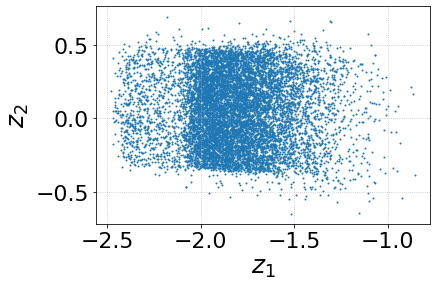

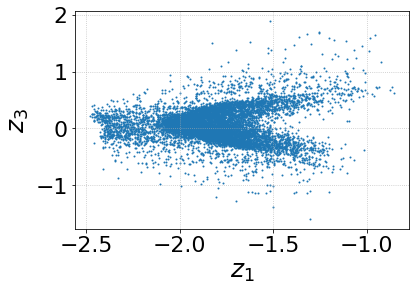

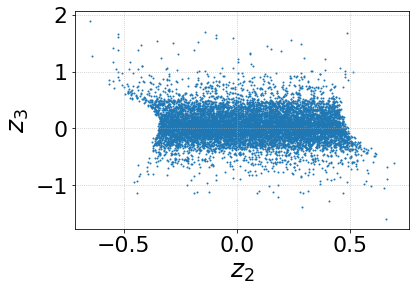

In [38]:
mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')

plt.figure()
plt.scatter(latent[:, 1], latent[:, 2], s=mksz)
plt.xlabel(r'$z_2$')
plt.ylabel(r'$z_3$')